In [1]:
import mxnet as mx
import autogluon as ag
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(f"mxnet version: {mx.__version__}")
print(f"autogluon version: {ag.__version__}")

mxnet version: 1.7.0
autogluon version: 0.0.15


# A Toy Reward Space

### Generate the simulation rewards as a mixture of 2 gaussians

In [2]:
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

x, y = np.linspace(0, 99, 100), np.linspace(0, 99, 100)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
ps = [(20, 70, 35, 40, 1),
      (80, 40, 20, 20, 0.7)]
for p in ps:
    Z += gaussian(X, Y, *p)

/home/rlan/anaconda3/envs/nas/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualize the reward space

Shapes: (100, 100), (100, 100), (100, 100)


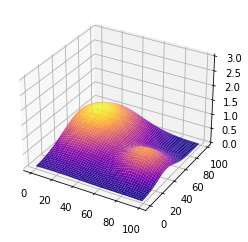

In [3]:
print(f"Shapes: {X.shape}, {Y.shape}, {Z.shape}")

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# Simulation Experiment

### Customize Train Function

We can define any function with a decorator @ag.args, which converts the function to AutoGluon searchable. The reporter is used to communicate with AutoGluon search algorithms.

In [4]:
@ag.args(
    x=ag.space.Categorical(*list(range(100))),
    y=ag.space.Categorical(*list(range(100))),
)
def rl_simulation(args, reporter):
    x, y = args.x, args.y
    reporter(accuracy=Z[y][x])

### Random Search Baseline

In [5]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=300,
                                              reward_attr='accuracy')
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'time_attr': Imputing default value epoch
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 300


  0%|          | 0/300 [00:00<?, ?it/s]

Best config: {'x▁choice': 22, 'y▁choice': 69}, best reward: 0.9961362873852471


### Reinforcement Learning

In [9]:
import tempfile
tmp_chkp_dir = tempfile.mkdtemp()

rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=300,
                                        reward_attr='accuracy',
                                        controller_batch_size=4,
                                        controller_lr=5e-3,
                                        checkpoint=f'{tmp_chkp_dir}/checkerpoint.ag')
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

AttributeError: '_io.BufferedRandom' object has no attribute 'mkdir'

### Compare the Performance

In [8]:
# Get the result history
results_rl = np.array([v[0]['accuracy'] for v in rl_scheduler.training_history.values()])
results_random = np.array([v[0]['accuracy'] for v in random_scheduler.training_history.values()])

# Average result every 10 trials
results1 = results_random.reshape(-1, 10).mean(axis=1)
results2 = results_rl.reshape(-1, 10).mean(axis=1)

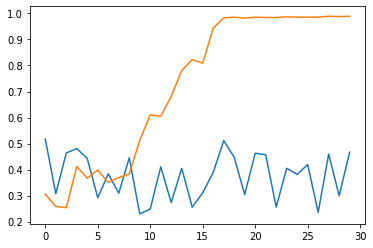

In [9]:
# Plot the results
plt.plot(range(len(results1)), results1, range(len(results2)), results2)